# Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install dependencies

In [ ]:
!pip install -q torch diffusers transformers accelerate datasets safetensors peft xformers tqdm matplotlib

# Imports

In [ ]:
import os
import torch
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from diffusers import StableDiffusionPipeline, DDPMScheduler
from diffusers.optimization import get_scheduler
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator
from peft import LoraConfig, get_peft_model
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from itertools import cycle

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


# Config

In [ ]:
# Device / Base Model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_MODEL = "runwayml/stable-diffusion-v1-5"

# Paths
LORA_ROOT = "/content/drive/MyDrive/Colab Notebooks/sd_lora"
DATA_ROOT = f"{LORA_ROOT}/dataset/train"
IMAGES_DIR = f"{DATA_ROOT}/images"
CAPTIONS_DIR = f"{DATA_ROOT}/captions"
OUTPUT_DIR = f"{LORA_ROOT}/outputs/unet_only"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Training Hyperparameters
UNET_LR = 1e-4
TEXT_ENCODER_LR = 5e-5
BATCH_SIZE = 4                     # Per-device batch size
GRADIENT_ACCUMULATION_STEPS = 4    # Effective batch size = BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS
RESOLUTION = 512
SEED = 42

# Training Settings
TRAIN_TEXT_ENCODER = False
TARGET_STEPS = 500
WARMUP_STEPS = max(1, int(0.05 * TARGET_STEPS))
SAVE_EVERY_STEPS = 200

EMA_ALPHA = 0.98
ROLLING_WINDOW = 100

# Reproducibility
torch.manual_seed(SEED)
random.seed(SEED)

# Dataset Definition

In [ ]:
class ImageCaptionDataset(Dataset):
    def __init__(self, images_dir, captions_dir, resolution=512, tokenizer=None):
        self.images_dir = Path(images_dir)
        self.captions_dir = Path(captions_dir)
        self.ids = sorted([p.stem for p in self.images_dir.glob("*.jpg")])
        self.resolution = resolution
        self.tokenizer = tokenizer

        # Optimized augmentation for food images
        self.transform = transforms.Compose([
            # Slight random crop and scale
            transforms.RandomResizedCrop(
                resolution, scale=(0.85, 1.0), ratio=(0.95, 1.05)
            ),
            # Horizontal flip
            transforms.RandomHorizontalFlip(p=0.5),
            # Small rotation
            transforms.RandomRotation(degrees=5),
            # Subtle color variation
            transforms.ColorJitter(
                brightness=0.1,
                contrast=0.1,
                saturation=0.05,
                hue=0.02
            ),
            # Random Gaussian blur applied to 30% of images
            transforms.RandomApply([
                transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 1.0))
            ], p=0.3),
            # Convert to tensor and normalize to [-1, 1]
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.ids)


    def __getitem__(self, idx):
        id_ = self.ids[idx]
        img = Image.open(self.images_dir / f"{id_}.jpg").convert("RGB")
        img = self.transform(img)
        caption = (self.captions_dir / f"{id_}.txt").read_text(encoding="utf-8").strip()
        inputs = self.tokenizer(caption, padding="max_length", truncation=True, max_length=77, return_tensors="pt")
        return {
            "pixel_values": img,
            "input_ids": inputs.input_ids[0],
            "attention_mask": inputs.attention_mask[0]
        }

# Load Models

In [ ]:
# Load base Stable Diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    BASE_MODEL,
    safety_checker=None
).to(DEVICE)

# Enable memory-efficient attention if xformers is installed
try:
    pipe.enable_xformers_memory_efficient_attention()
    print("xformers enabled")
except Exception as e:
    print("xformers not available or failed to enable:", e)

# Extract pipeline components
vae = pipe.vae
unet = pipe.unet

# Free the pipeline object to save GPU memory
del pipe
torch.cuda.empty_cache()

# Load tokenizer and text encoder separately
tokenizer = CLIPTokenizer.from_pretrained(BASE_MODEL, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(BASE_MODEL, subfolder="text_encoder").to(DEVICE)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


xformers enabled


# Setup Lora Configs

In [ ]:
# LoRA config for UNet
unet_lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["to_q", "to_k", "to_v"],
    lora_dropout=0.05,
    bias="none",
)
unet = get_peft_model(unet, unet_lora_config)
unet.print_trainable_parameters()

if TRAIN_TEXT_ENCODER:
  # LoRA config for TEXT ENCODER
  text_lora_config = LoraConfig(
      r=4,
      lora_alpha=16,
      target_modules=["q_proj", "v_proj"],
      lora_dropout=0.05,
      bias="none",
  )
  text_encoder = get_peft_model(text_encoder, text_lora_config)
  text_encoder.print_trainable_parameters()


trainable params: 1,195,008 || all params: 860,715,972 || trainable%: 0.1388


# Dataloader Setup

In [ ]:
# Stacks pixel values, input IDs, and attention masks into tensors
def collate_fn(examples):
    pixel_values = torch.stack([e["pixel_values"] for e in examples])
    input_ids = torch.stack([e["input_ids"] for e in examples])
    attention_mask = torch.stack([e["attention_mask"] for e in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids, "attention_mask": attention_mask}

# Create dataset for image-caption pairs
dataset = ImageCaptionDataset(IMAGES_DIR, CAPTIONS_DIR, resolution=RESOLUTION, tokenizer=tokenizer)

# DataLoader for batching during training
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# Training loop

Training LoRA:  40%|████      | 200/500 [26:15<39:25,  7.89s/it, step=200, loss=0.1055, ema=0.1569, roll=0.1539, grad=0.0067, lr=6.32e-05]

Saved checkpoint to /content/drive/MyDrive/Colab Notebooks/sd_lora/outputs/unet_only/checkpoint-step200


Training LoRA:  80%|████████  | 400/500 [52:19<13:08,  7.88s/it, step=400, loss=0.2184, ema=0.1630, roll=0.1632, grad=0.0087, lr=2.11e-05]

Saved checkpoint to /content/drive/MyDrive/Colab Notebooks/sd_lora/outputs/unet_only/checkpoint-step400


Training LoRA: 100%|██████████| 500/500 [1:05:24<00:00,  7.85s/it, step=500, loss=0.1418, ema=0.1608, roll=0.1582, grad=0.0084, lr=0.00e+00]


Final checkpoint saved to: /content/drive/MyDrive/Colab Notebooks/sd_lora/outputs/unet_only/checkpoint-step500


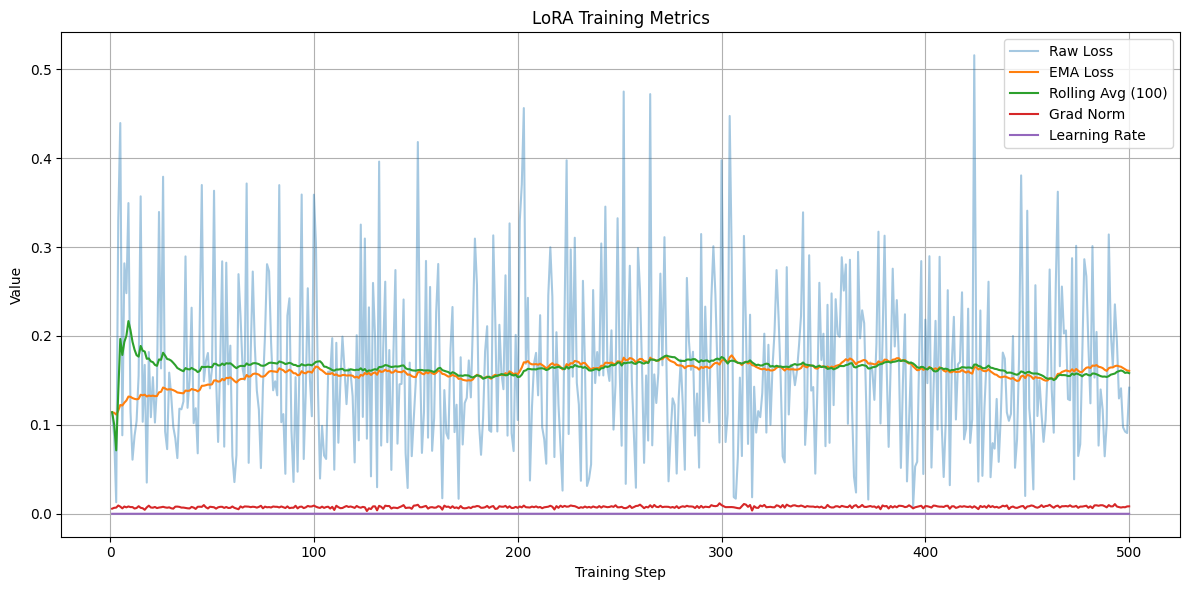

In [ ]:

# ==================== Accelerator ====================
accelerator = Accelerator(
    mixed_precision="fp16",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

# ==================== Optimizer & Scheduler ====================
if TRAIN_TEXT_ENCODER:
    optimizer = torch.optim.AdamW(
        [
            {"params": unet.parameters(), "lr": UNET_LR},
            {"params": text_encoder.parameters(), "lr": TEXT_ENCODER_LR},
        ]
    )
else:
    optimizer = torch.optim.AdamW(unet.parameters(), lr=UNET_LR)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=TARGET_STEPS
)

noise_scheduler = DDPMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000
)

# ==================== Prepare models & dataloader ====================
unet, vae, text_encoder, optimizer, dataloader, lr_scheduler = accelerator.prepare(
    unet, vae, text_encoder, optimizer, dataloader, lr_scheduler
)

vae.eval()
if TRAIN_TEXT_ENCODER:
    text_encoder.train()
else:
    text_encoder.eval()
unet.train()

# ==================== Metrics Tracking ====================
loss_history = []
ema_loss_history = []
rolling_loss_history = []
grad_norm_history = []
lr_history = []

ema_loss = None
global_step = 0

# ==================== Training Loop ====================
pbar = tqdm(total=TARGET_STEPS, desc="Training LoRA", dynamic_ncols=False, leave=True)

while global_step < TARGET_STEPS:
    for batch in dataloader:
        with accelerator.accumulate(unet):
            pixel_values = batch["pixel_values"].to(DEVICE, dtype=torch.float32)
            input_ids = batch["input_ids"].to(DEVICE)

            # Encode images
            with torch.no_grad():
                latents = vae.encode(pixel_values).latent_dist.sample() * 0.18215
            latents = latents.to(unet.dtype)

            # Encode text
            if TRAIN_TEXT_ENCODER:
                text_embeddings = text_encoder(input_ids)[0]
            else:
                with torch.no_grad():
                    text_embeddings = text_encoder(input_ids)[0]

            # Add noise
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device
            )
            noise = torch.randn_like(latents)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # UNet forward
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample

            # Compute loss
            loss = torch.nn.functional.mse_loss(model_pred.float(), noise.float(), reduction="mean")
            accelerator.backward(loss)

            # Optimizer step only on sync_gradients
            if accelerator.sync_gradients:
                # Clip gradients safely on CPU
                params = list(unet.parameters())
                if TRAIN_TEXT_ENCODER:
                    params += list(text_encoder.parameters())
                grad_norm = accelerator.clip_grad_norm_(params, 1.0).cpu().item()

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

                # Update step
                global_step += 1

                # Logging
                step_loss = accelerator.gather(loss).mean().detach().cpu().item()
                loss_history.append(step_loss)
                ema_loss = step_loss if ema_loss is None else EMA_ALPHA * ema_loss + (1 - EMA_ALPHA) * step_loss
                ema_loss_history.append(ema_loss)
                rolling_loss_history.append(sum(loss_history[-ROLLING_WINDOW:]) / len(loss_history[-ROLLING_WINDOW:]))
                grad_norm_history.append(grad_norm)
                lr_history.append(optimizer.param_groups[0]["lr"])

                pbar.set_postfix({
                    "step": global_step,
                    "loss": f"{step_loss:.4f}",
                    "ema": f"{ema_loss:.4f}",
                    "roll": f"{rolling_loss_history[-1]:.4f}",
                    "grad": f"{grad_norm:.4f}",
                    "lr": f"{lr_history[-1]:.2e}"
                })
                pbar.update(1)

                # Save checkpoint
                if global_step % SAVE_EVERY_STEPS == 0:
                    cp_path = Path(OUTPUT_DIR) / f"checkpoint-step{global_step}"
                    (cp_path / "unet").mkdir(parents=True, exist_ok=True)
                    accelerator.unwrap_model(unet).save_pretrained(str(cp_path / "unet"))
                    if TRAIN_TEXT_ENCODER:
                        (cp_path / "text_encoder").mkdir(parents=True, exist_ok=True)
                        accelerator.unwrap_model(text_encoder).save_pretrained(str(cp_path / "text_encoder"))
                    pbar.write(f"Saved checkpoint to {cp_path}")

                if global_step >= TARGET_STEPS:
                    break
    if global_step >= TARGET_STEPS:
        break

pbar.close()

# ==================== Final checkpoint ====================
final_cp_path = Path(OUTPUT_DIR) / f"checkpoint-step{global_step}"
(final_cp_path / "unet").mkdir(parents=True, exist_ok=True)
accelerator.unwrap_model(unet).save_pretrained(str(final_cp_path / "unet"))

if TRAIN_TEXT_ENCODER:
    (final_cp_path / "text_encoder").mkdir(parents=True, exist_ok=True)
    accelerator.unwrap_model(text_encoder).save_pretrained(str(final_cp_path / "text_encoder"))

print("Final checkpoint saved to:", final_cp_path)

# Plotting curves

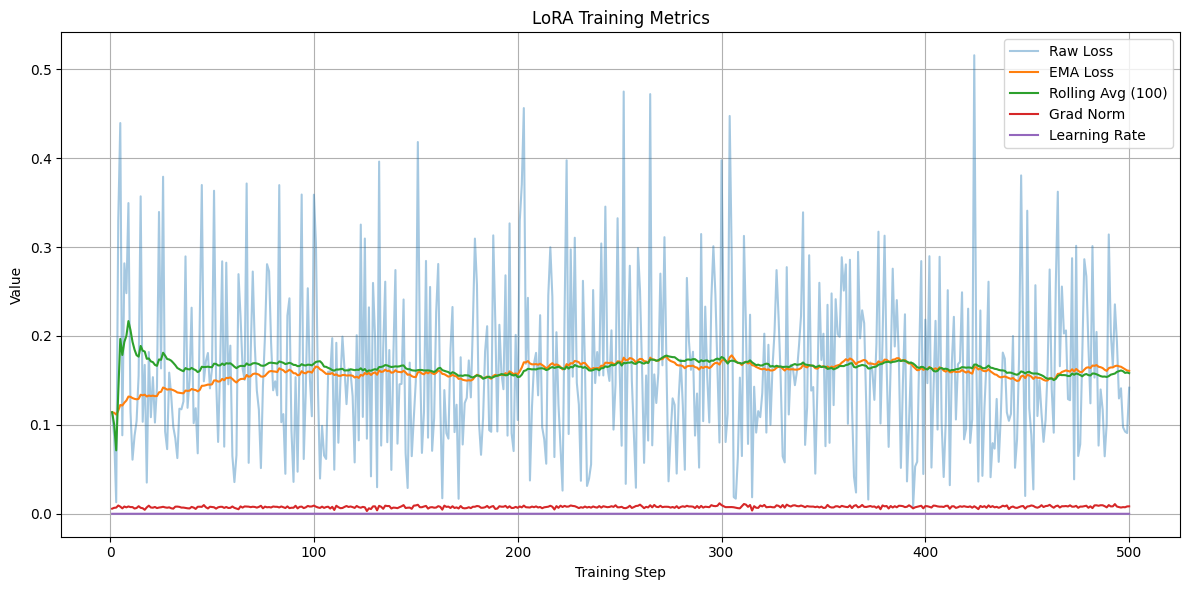

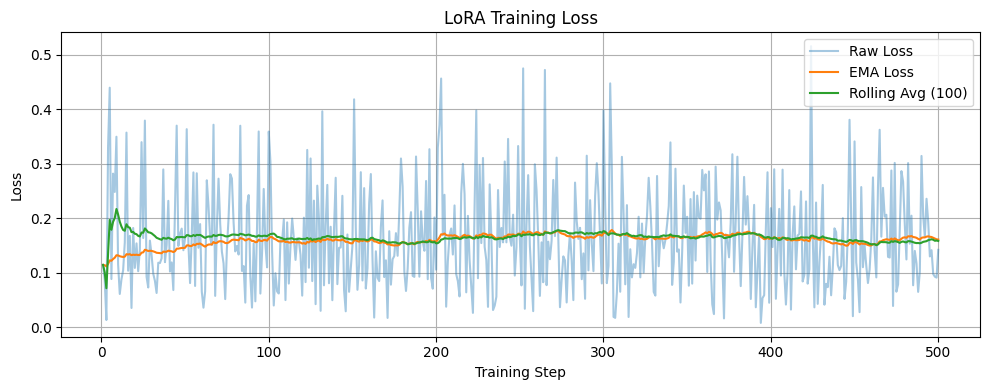

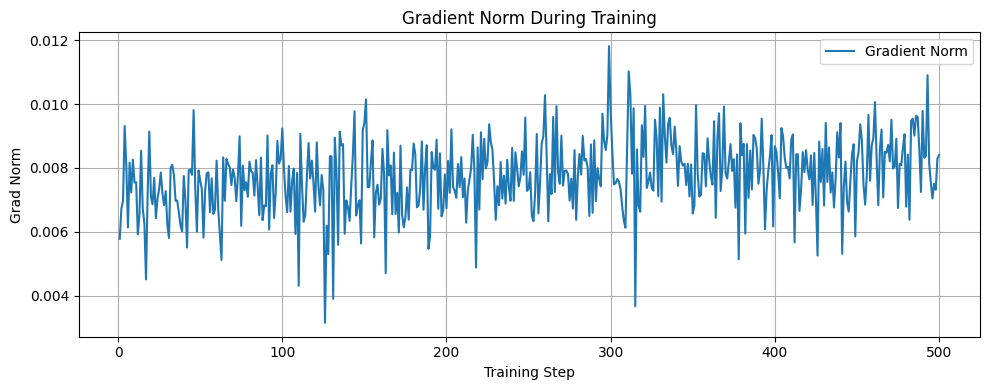

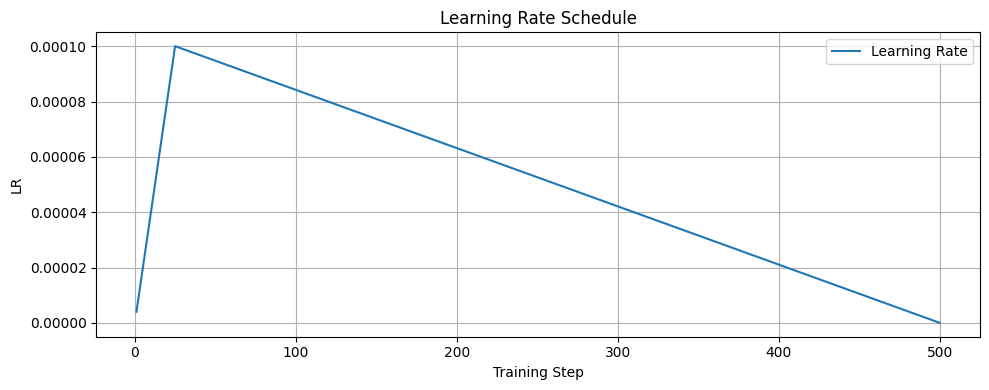

In [ ]:
steps = range(1, len(loss_history) + 1)
# ==================== Loss + Metrics together ====================
plt.figure(figsize=(12, 6))

plt.plot(steps, [float(x) for x in loss_history], label="Raw Loss", alpha=0.4)
plt.plot(steps, [float(x) for x in ema_loss_history], label="EMA Loss")
plt.plot(steps, [float(x) for x in rolling_loss_history], label=f"Rolling Avg ({ROLLING_WINDOW})")
plt.plot(steps, [float(x) for x in grad_norm_history], label="Grad Norm")
plt.plot(steps, [float(x) for x in lr_history], label="Learning Rate")

plt.xlabel("Training Step")
plt.ylabel("Value")
plt.title("LoRA Training Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==================== Loss Curves ====================
plt.figure(figsize=(10, 4))
plt.plot(steps, [float(x) for x in loss_history], label="Raw Loss", alpha=0.4)
plt.plot(steps, [float(x) for x in ema_loss_history], label="EMA Loss")
plt.plot(steps, [float(x) for x in rolling_loss_history], label=f"Rolling Avg ({ROLLING_WINDOW})")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("LoRA Training Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==================== Gradient Norm ====================
plt.figure(figsize=(10, 4))
plt.plot(steps, [float(x) for x in grad_norm_history], label="Gradient Norm")
plt.xlabel("Training Step")
plt.ylabel("Grad Norm")
plt.title("Gradient Norm During Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==================== Learning Rate ====================
plt.figure(figsize=(10, 4))
plt.plot(steps, [float(x) for x in lr_history], label="Learning Rate")
plt.xlabel("Training Step")
plt.ylabel("LR")
plt.title("Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Load and try LoRA weights

In [ ]:
# Load base model
pipe = StableDiffusionPipeline.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

# Enable xformers memory efficient attention if available
try:
    pipe.enable_xformers_memory_efficient_attention()
except Exception:
    pass

# Load LoRA weights for UNet
pipe.load_lora_weights(f"{OUTPUT_DIR}/checkpoint-step500/unet")

# Optionally load LoRA weights for Text Encoder if they exist
te_lora_path = f"{OUTPUT_DIR}/checkpoint-step500/text_encoder"
if os.path.exists(te_lora_path):
    pipe.load_lora_weights(te_lora_path)
    print("Text Encoder LoRA weights loaded.")

# Generate image
prompt = "Hearty Serbian bean stew with smoked pork"
image = pipe(
    prompt,
    num_inference_steps=30,
    guidance_scale=7.5
).images[0]

# Save image
image.save(f"{LORA_ROOT}/training/test_img.png")
print(f"Image generated and saved to {LORA_ROOT}/training/test_img.png")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/is

  0%|          | 0/30 [00:00<?, ?it/s]

Image generated and saved to /content/drive/MyDrive/Colab Notebooks/sd_lora/training/test_img.png
